# Adults Census Model Training with Scikit-learn in Azure ML hardware and local hardware

## Scikit-learn SVM Algorithm
### Azure Machine Learning Service Framework

[Analysis](#compaire)

- **Performance metrics for Local and Azure Notebook are equal.**
- Azure Designer Performance metrics are diffrent with locally trained.


## Outline

1. [Setup Development Environment](#setup)
2. [Data Preparation](#data_prep)
3. [Model Training](#train)
4. [Model Comparison](#compaire)
5. [Adversarially train a robust classifier](#adv_training)
6. [Evaluate the robust classifier](#evaluation)

<a id="setup"></a>
### 1 Set up Development Environment
**Ref: Exp-2_train_adult_DecisionTree_Azure-v2.ipynb**

In [3]:
# Initialize workspace

# base packages to work with AMLS
import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Ready to use Azure ML", azureml.core.VERSION)

# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')

Ready to use Azure ML 1.19.0
unive-workspace	westeurope	unive-resource-group	westeurope


<a id="data_prep"></a>
### 2. Data Preparation

**Ref: Exp-2_train_adult_DecisionTree_Azure-v2.ipynb**


<a id="train"></a>
### 3 Model Training

- [3.1 Prepare a training script](#3_1)
- [3.2 Train Model](#3_2)


<a id="3_1"></a>
#### 3.1 Prepare a training script
The below script contains training model and can run (model training) both in AMLS cluster hardware for model training name: 

- cluster: cpu-standard-ds1-v2

Ref: /mnt/batch/tasks/shared/LS_root/mounts/clusters/cpu-standard-ds1-v2/code/Users/877159/script

In [4]:
# Directory to write training script.
# Code Directory
import os
script_folder = os.path.join(os.getcwd(), "script")
os.makedirs(script_folder, exist_ok=True)
print(script_folder)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/cpu-standard-ds1-v2/code/Users/877159/script


In [5]:
%%writefile $script_folder/train_adult_SVC.py
import os
import time
import argparse
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC

from azureml.core import Run, Dataset

if __name__ =='__main__':
    
    start_time = time.time()
    
    print('extracting arguments')
    parser = argparse.ArgumentParser()
    
    # Get the experiment run context
    run = Run.get_context()

    # hyperparameters will be passed as arguments to the script.
    # example: sklearn SVC hyperparameters
    parser.add_argument('--max-iter', type=int, default=1000)
    
    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str)
    args, _ = parser.parse_known_args()

    # load the diabetes dataset
    dataset_name = 'adult-dataset'
    print("Loading data from " + dataset_name)
    df = Dataset.get_by_name(workspace=run.experiment.workspace, name=dataset_name).to_pandas_dataframe()
          
    #Prepocessing
    print('building datasets')
    target = 'IncomeGroup'
    features = "age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country"
    X = df[features.split()]
    y = df[target]

    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    
    cat_ix = X.select_dtypes(include=['object', 'bool']).columns
    print(f"cat_ix: {cat_ix}")
    num_ix = X.select_dtypes(include=['int64', 'float64']).columns
    print(f"num_ix: {num_ix}")
    
    #use stratify for un balanced number of examples for each class label
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)
    print(f"X_train:{X_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_train:{y_train.shape}")
    print(f"y_test: {y_test.shape}")
          
    # Model Training: Support Vector Machines
    print('training model')
    MODEL = 'SVC'
    # define steps
    model = SVC(gamma='scale', probability = True, max_iter = args.max_iter)
    
    steps = [('c',OneHotEncoder(handle_unknown='ignore'),cat_ix), ('n',MinMaxScaler(),num_ix)]
    # one hot encode categorical, normalize numerical
    ct = ColumnTransformer(steps)
    # wrap the model a pipeline
    pipe  = Pipeline(steps=[('transformer',ct),('svc',model)])
    pipe.fit(X_train, y_train)
    print(f"transformer: {pipe['transformer']}")
    print(f"model: {pipe['svc']}")
          
    ## Evaluate the model

    # using threshold
    threshold = 0.5 # set threshold as 0.5
    y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int) 
    print(f"y_pred: {y_pred}")
    run.log('y_pred:', y_pred)
    print(f'Misclassified examples:{(y_test != y_pred).sum()}')
    run.log('Misclassified examples:', (y_test != y_pred).sum())
    print(pipe.predict_proba(X_test))
          
    print(f"distinct y_pred: {np.unique(y_pred)}")
    print(f"distinct y_test: {np.unique(y_test)}")
          
    # Confusion Matrix
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    print(f"confusion matrix:\n {conf_mat}")
    run.log('confusion matrix:', conf_mat)
    
    # AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    print(f"auc: {auc}")
    run.log('auc:', auc)
    
    # Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}") 
    run.log('Accuracy:', accuracy)

    # Precision
    precision = metrics.precision_score(y_test, y_pred)
    print(f"Precision: {precision}")
    run.log('Precision:', precision )

    # Recall
    recall = metrics.recall_score(y_test, y_pred)
    print(f"Recall: {recall}")
    run.log('Recall:', recall)

    # F1
    f1 = metrics.f1_score(y_test, y_pred)
    print(f"F1: {f1}")
    run.log('F1:', f1)

    
    # classification_report
    print('classification_report')
    print(metrics.classification_report(y_test, y_pred))
    run.log('classification_report', metrics.classification_report(y_test, y_pred))

    # Save model
    os.makedirs('outputs', exist_ok=True)
    joblib.dump(value = pipe, filename = f"outputs/{MODEL}.joblib")

    time_elapsed = (time.time() - start_time)
    print("Computational time:{}".format(time_elapsed))

    # Graph 3
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    run.log_image('conf_mat', plot=plt)

Writing /mnt/batch/tasks/shared/LS_root/mounts/clusters/cpu-standard-ds1-v2/code/Users/877159/script/train_adult_SVC.py


<a id="3_2"></a>
#### 3.2 Train Model

- [3.2.1 Run model Training to the Compute Cluster](#cluster)
    - [3.2.1.1 Cluster architecture](#3_2_1_1)
    - [3.2.1.2 Initialize an Experiment](#3_2_1_2)
    - [3.2.1.3 Initialize dataset](#3_2_1_3)
    - [3.2.1.4 Create and install python environment](#3_2_1_4)
    - [3.2.1.5 Configure and submit your training run](#3_2_1_5)
- [3.2.2 Run model Training to local desktop computer](#desktop)

<a id="cluster"></a>
##### 3.2.1 Run model Training to the Compute Cluster

To submit a training script on created cluster

<a id="3_2_1_1"></a>
###### 3.2.1.1 Cluster architecture

In [2]:
# Python implementation: CPython
# Python version       : 3.6.8

# Compiler    : GCC 7.3.0
# OS          : Linux
# Release     : 4.15.0-1098-azure
# Machine     : x86_64
# Processor   : x86_64
# CPU cores   : 1
# Architecture: 64bit

# Hostname: e6288471d32946869b90a8531cc6d254000000 

<a id="3_2_1_2"></a>
###### 3.2.1.2 Initialize an Experiment 

In [12]:
# Name your experiment here.
experiment_name = 'adult-DecisionTree'

from azureml.core import Experiment
experiment = Experiment(workspace=ws, name=experiment_name)
print(f"Experiment: {experiment.name}")

Experiment: adult-DecisionTree


<a id="3_2_1_3"></a>
###### 3.2.1.3 Initialize dataset 

In [13]:
from azureml.core import Dataset

ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)

#Create a tabular dataset from the path on the datastore (this may take a short while)
data_set = Dataset.Tabular.from_delimited_files(path=(ds, 'adults-data/adult.csv'))

AzureBlob univeworstorage001930301 azureml-blobstore-0c276c1c-6e6d-4bdf-a955-8931bdfe9925


In [14]:
dataset_name = 'adult-dataset'
df = Dataset.get_by_name(workspace=ws, name=dataset_name).to_pandas_dataframe()

print(df.shape)
print(df.columns)

(45222, 15)
Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'IncomeGroup'],
      dtype='object')


<a id="3_2_1_4"></a>
###### 3.2.1.4 Create and install python environment

In [15]:
## Createnvironment
# These environments are backed by cached Docker images which reduces the run preparation cost.

from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

# select sklearn Python environment
env = Environment("azml-Scikitlearn-env")
# Create a set of package dependencies (conda or pip as required)
conda_dep =  CondaDependencies.create(conda_packages=['pandas','numpy','scikit-learn','joblib','ipykernel','matplotlib','lightgbm'],
                                          pip_packages=['azureml-sdk','argparse','pyarrow','watermark'])


# Adds dependencies to PythonSection of env
env.python.conda_dependencies=conda_dep
env.register(workspace=ws)

print("AzureML-Scikit-learn-0.20.3 packages:", env.python.conda_dependencies.serialize_to_string())

AzureML-Scikit-learn-0.20.3 packages: # Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-sdk~=1.19.0
  - argparse
  - pyarrow
  - watermark
- pandas
- numpy
- scikit-learn
- joblib
- ipykernel
- matplotlib
- lightgbm
channels:
- anaconda
- conda-forge



<a id="3_2_1_5"></a>
###### 3.2.1.5 Configure and submit your training run 

In [16]:
# credit: https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.script_run_config.scriptrunconfig?view=azure-ml-py

from azureml.core.compute import AmlCompute
from azureml.core import ScriptRunConfig, Experiment

# retrieve an environment
env = Environment.get(ws, name=env.name)

# load an experiment
experiment = Experiment(ws, experiment_name)

# retrieve a compute target
cluster = ws.compute_targets['cpu-cluster']

# configure and submit your training run
config = ScriptRunConfig(source_directory=script_folder,
                         command=['python', 'train_adult_SVC.py', 
                                  '--max-iter', '-1',
                                  '--model-dir', script_folder
                                  ],
                         compute_target=cluster,
                         environment=env)

script_run = experiment.submit(config)
script_run

Experiment,Id,Type,Status,Details Page,Docs Page
adult-DecisionTree,adult-DecisionTree_1607736787_e23b9286,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [17]:
%%time
# specify show_output to True for a verbose log
script_run.wait_for_completion(show_output=True)

RunId: adult-DecisionTree_1607736787_e23b9286
Web View: https://ml.azure.com/experiments/adult-DecisionTree/runs/adult-DecisionTree_1607736787_e23b9286?wsid=/subscriptions/79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5/resourcegroups/unive-resource-group/workspaces/unive-workspace

Execution Summary
RunId: adult-DecisionTree_1607736787_e23b9286
Web View: https://ml.azure.com/experiments/adult-DecisionTree/runs/adult-DecisionTree_1607736787_e23b9286?wsid=/subscriptions/79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5/resourcegroups/unive-resource-group/workspaces/unive-workspace

CPU times: user 32.9 ms, sys: 0 ns, total: 32.9 ms
Wall time: 427 ms


{'runId': 'adult-DecisionTree_1607736787_e23b9286',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-12-12T01:42:02.444223Z',
 'endTimeUtc': '2020-12-12T01:49:57.724209Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'c97cdc35-1551-400f-a76f-f4bb11ab3747',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '0e33c5b9-a072-4cbb-b09b-7ba2da209656'}, 'consumptionDetails': {'type': 'Reference'}}],
 'outputDatasets': [],
 'runDefinition': {'script': None,
  'command': 'python train_adult_SVC.py --max-iter -1 --model-dir /mnt/batch/tasks/shared/LS_root/mounts/clusters/cpu-standard-ds1-v2/code/Users/877159/script',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'cpu-cluster',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  

<a id="desktop"></a>
##### 3.2.2 Run model Training to local desktop computer

**Ref: Exp-2_train_adult_SVC_SageMaker-v3.ipynb**

<a id="compaire"></a>
### 4 Model Comparison

Note: **similar**

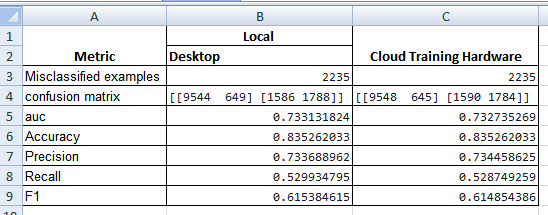

In [2]:
from IPython.display import Image

Image(filename='images/Azure/Exp-2/SVC/metric-compair.png')

#### some screenshots from Azure Model Training hardware

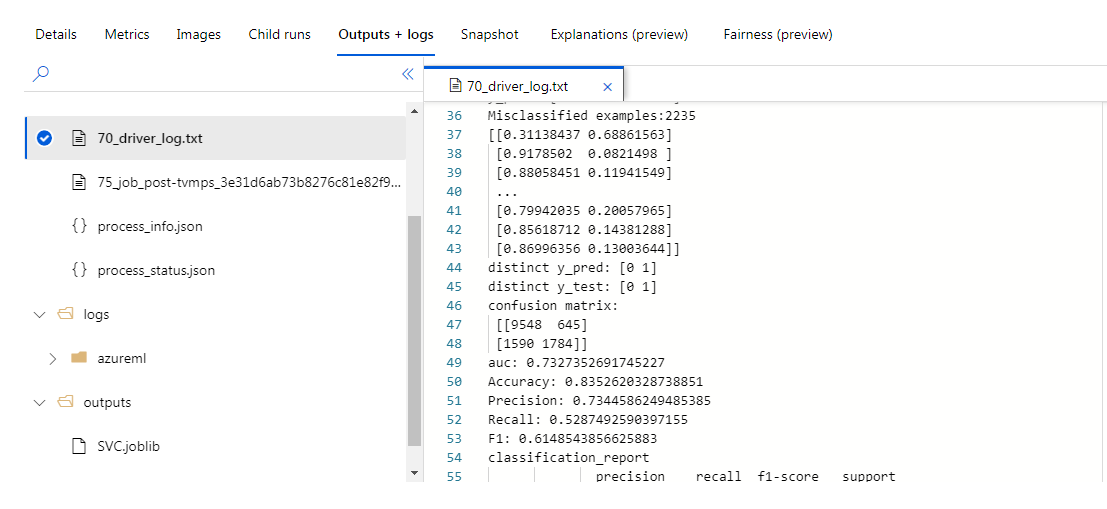

In [3]:
Image(filename='images/Azure/Exp-2/SVC/driver_log.png')

<a id="adv_training"></a>
### 5 Adversarially train a robust classifier

Adversarial-Robustness-Toolbox for scikit-learn DecisionTree

Refer: Exp-2_train_adult_SVC_SageMaker-v3.ipynb

<a id="evaluation"></a>
### 6 Evaluate the robust classifier 
Evaluate DecisionTreesClassifier on benign and adversarial samples

Refer: Exp-2_train_adult_SVC_SageMaker-v3.ipynb